In [1]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

CATEGORIES = ['Electron','Muon','Tau','Quark']

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_in = open("XLEP.pickle","rb")
X0 = pickle.load(pickle_in)

pickle_in = open("yLEP.pickle","rb")
z0 = pickle.load(pickle_in)

X = np.array(X0)

y = np.array(z0)

array([ 1.14367676e+00,  9.29805219e-01,  9.29267645e-01, -9.30635810e-01,
        1.09610632e-02,  9.37013702e+01,  0.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  8.81172657e+00,  7.22930527e+01,
        9.99872506e-01,  1.82751548e+00])

In [3]:
df = 10
X_test = np.array([X[i] for i in range((len(X)//df))])
X_train = np.array([X[i] for i in range((len(X)//df),len(X))])

y_test = np.array([y[i] for i in range((len(y)//df))])
y_train = np.array([y[i] for i in range((len(y)//df),len(y))])

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
new_model = tf.keras.models.load_model('fst-LEP-0.1-dr-128-l-1-de.model') #loading the model

In [20]:
predictions = new_model.predict(X_test)

In [21]:
score = new_model.evaluate(X_test,y_test)

40000/40000 [==============================] - 2s 39us/step


In [22]:
score

[0.03463609146872768, 0.9864]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268D365B4E0>]],
      dtype=object)

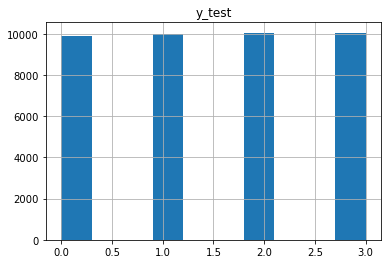

In [10]:
pd_y_t = pd.DataFrame({'y_test':y_test})
pd_y_t.hist()

In [23]:


import pandas as pd
df = pd.DataFrame({'y_test': y_test})
#df['y_pred'] = np.array(predictions)

#creating a array with the predictions
y_pred = [np.argmax(predictions[i]) for i in range(len(y_test))]
y_prob = [predictions[i][np.argmax(predictions[i])] for i in range(len(y_test))]


pd_y_test = pd.DataFrame({'y_test':y_test})
pd_y_prob = pd.DataFrame({'y_prob':y_prob})
pd_y_pred = pd.DataFrame({'y_pred':y_pred})

df_final = pd.concat([pd_y_pred, pd_y_test,pd_y_prob], axis=1)

df_final.head(10)


#evaluating the completeness
#df_finalsh = df_final.sample(frac=1).reset_index(drop=True)  #shuffle the rows only

df_final_0 = df_final[df_final['y_test'] == 0]
df_final_1 = df_final[df_final['y_test'] == 1]
df_final_2 = df_final[df_final['y_test'] == 2]
df_final_3 = df_final[df_final['y_test'] == 3]

n0 = df_final_0[df_final_0.y_pred == 0]    # correct predictions for class-0 / threshold=0
n1 = df_final_1[df_final_1.y_pred == 1]    # correct predictions for class-1 / threshold=0
n2 = df_final_2[df_final_2.y_pred == 2]    # correct predictions for class-2 / threshold=0
n3 = df_final_3[df_final_3.y_pred == 3]    # correct predictions for class-3 / threshold=0

n_0 = n0.count()                           #number of correct predictions for class-0 / threshold=0
n_1 = n1.count()                           #number of correct predictions for class-1 / threshold=0
n_2 = n2.count()                           #number of correct predictions for class-0 / threshold=0
n_3 = n3.count()                           #number of correct predictions for class-0 / threshold=0

count_0 = df_final_0['y_test'].count()     #get the lenght of the sample of class-0,1 and 2
count_1 = df_final_1['y_test'].count()
count_2 = df_final_2['y_test'].count()
count_3 = df_final_3['y_test'].count()

print("Efficiency:", CATEGORIES[0], n_0[0]/count_0)
print("Efficiency:", CATEGORIES[1],n_1[0]/count_1)
print("Efficiency:",CATEGORIES[2],n_2[0]/count_2)
print("Efficiency:",CATEGORIES[3],n_3[0]/count_3)



Efficiency: Electron 0.9957639939485627
Efficiency: Muon 0.9901970591177354
Efficiency: Tau 0.9637068708362335
Efficiency: Quark 0.9961120526368259


# How to create a ROC curve? Varying the threshold: 
#https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0


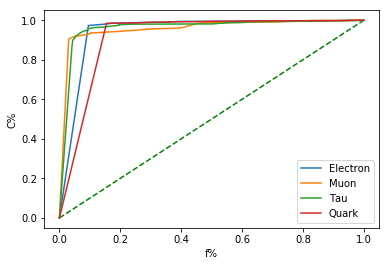

In [24]:

shift = 100
threshold = [i/shift for i in range(shift+1)]
count_0_ROC = []
count_1_ROC = []
count_2_ROC = []
count_3_ROC = []

countf_0_ROC = []
countf_1_ROC = []
countf_2_ROC = []
countf_3_ROC = []

for thr in threshold:
    #count the True positive of class-0,1, and 2 :
    n0tp_ROC = n0[n0.y_prob > thr].count()        
    n1tp_ROC = n1[n1.y_prob > thr].count()        
    n2tp_ROC = n2[n2.y_prob > thr].count()
    n3tp_ROC = n3[n3.y_prob > thr].count()
    
    #count the False negative of class-0,1 and 2:
    n0fn_ROC = n0[n0.y_prob < thr].count()              
    n1fn_ROC = n1[n1.y_prob < thr].count()             
    n2fn_ROC = n2[n2.y_prob < thr].count()             
    n3fn_ROC = n3[n3.y_prob < thr].count()             
        
    # false positive for class-0,1 and 2:
    n0fp_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob > thr)].count()
    n1fp_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob > thr)].count()  
    n2fp_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob > thr)].count()  
    n3fp_ROC = df_final_3[(df_final_3.y_pred != 3) & (df_final_3.y_prob > thr)].count()  
    
   # true negative for class-0,1 and 2:
    n0tn_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob < thr)].count()
    n1tn_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob < thr)].count() 
    n2tn_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob < thr)].count() 
    n3tn_ROC = df_final_3[(df_final_3.y_pred != 3) & (df_final_3.y_prob < thr)].count() 

 # first type of TPR FPR definition
    #creating a list with the results for TPR and FPR:
#    count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] +n0fp_ROC[0]))     #TPR = true positive / (true positive + false positive)  
#    count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] +n1fp_ROC[0]))
#    count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] +n2fp_ROC[0]))
    
#    countf_0_ROC.append(n0fp_ROC[0]/(n0fn_ROC[0] +n0tn_ROC[0]))   #FPR = false positive/(false negative + true negative)
#    countf_1_ROC.append(n1fp_ROC[0]/(n1fn_ROC[0] +n1tn_ROC[0])) 
#    countf_2_ROC.append(n2fp_ROC[0]/(n2fn_ROC[0] +n2tn_ROC[0])) 
    
  # second type of TPR FPR definition  (seems better)
#    #creating a list with the results for TPR and FPR:
    count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] + n0fn_ROC[0]))     #TPR = true positive / (true positive + true negative)  
    count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] + n1fn_ROC[0]))
    count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] + n2fn_ROC[0]))
    count_3_ROC.append(n3tp_ROC[0]/(n3tp_ROC[0] + n3fn_ROC[0]))
    
    countf_0_ROC.append(n0fp_ROC[0]/(n0tn_ROC[0] + n0fp_ROC[0]))   #FPR = false positive/(false negative + false positive)
    countf_1_ROC.append(n1fp_ROC[0]/(n1tn_ROC[0] + n1fp_ROC[0])) 
    countf_2_ROC.append(n2fp_ROC[0]/(n2tn_ROC[0] + n2fp_ROC[0]))     
    countf_3_ROC.append(n3fp_ROC[0]/(n3tn_ROC[0] + n3fp_ROC[0]))     

    
TPR =[count_0_ROC,count_1_ROC,count_2_ROC,count_3_ROC]
FPR = [countf_0_ROC,countf_1_ROC,countf_2_ROC,countf_3_ROC]

x = np.linspace(0, 1, 1000)

fig, ax = plt.subplots()
ax.plot(x, x, '--g')

for j in range(len(CATEGORIES)):
    plt.plot(FPR[j], TPR[j],label= CATEGORIES[j])
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('f%')
plt.ylabel('C%')

In [26]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit

#https://micropore.wordpress.com/2017/02/04/python-fit-with-error-on-y-axis/


k = 0  #noise size
nstd = 1. # to draw x-sigma intervals


def func(x, b ):

    return(np.tanh(b*x))

# data 
x_0 = np.array(FPR[0])
x_1 = np.array(FPR[1])
x_2 = np.array(FPR[2])
x_3 = np.array(FPR[3])

y_0 = np.array(TPR[0])
y_1 = np.array(TPR[1])
y_2 = np.array(TPR[2])
y_3 = np.array(TPR[3])

# curve fit [with only y-error]
popt_0, pcov_0 = curve_fit(func, x_0, y_0) # ,sigma=1./(noise_0*noise_0)
perr_0 = np.sqrt(np.diag(pcov_0))
popt_1, pcov_1 = curve_fit(func, x_1, y_1) # ,sigma=1./(noise_1*noise_1)
perr_1 = np.sqrt(np.diag(pcov_1))
popt_2, pcov_2 = curve_fit(func, x_2, y_2) # ,sigma=1./(noise_2*noise_2)
perr_2 = np.sqrt(np.diag(pcov_2))
popt_3, pcov_3 = curve_fit(func, x_3, y_3) # ,sigma=1./(noise_2*noise_2)
perr_3 = np.sqrt(np.diag(pcov_3))


fit_0 = func(x_0, popt_0)
fit_1 = func(x_1, popt_1)
fit_2 = func(x_2, popt_2)

from scipy import integrate
f0=func(x,popt_0)
AUC_0 = integrate.quad(func, 0, 1,args=popt_0)
AUC_1 = integrate.quad(func, 0, 1,args=popt_1)
AUC_2 = integrate.quad(func, 0, 1,args=popt_2)
print('AUC parameter class 0:',str(AUC_0[0]) + '+-' + str(AUC_0[1]) )
print('AUC parameter class 1:',str(AUC_1[0]) + '+-' + str(AUC_1[1]) )
print('AUC parameter class 2:',str(AUC_2[0]) + '+-' + str(AUC_2[1]) )

AUC parameter class 0: 0.9677531079651478+-1.724266356726788e-13
AUC parameter class 1: 0.9848090206594811+-9.093205262399014e-13
AUC parameter class 2: 0.976823322326934+-7.627541694028171e-11
